# Introduction

**Objective**  
Performed exploratory data analysis to identify high-traffic times and locations within the New York City Subway system where street marketing would be most impactful

**Data Sources**
* http://web.mta.info/developers/data/nyct/turnstile/
* http://web.mta.info/developers/data/nyct/subway/Stations.csv
* NYC Census Jan-09-2020

**Featured Techniques**
* Python
* Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import locale
from locale import atof

%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

# Importing & Cleaning Data

Before merging the two datasets, files will be laoded and cleaned to ensure that formatting is consistant across the datasets.

## Turnstyle Data

### Importing

In [2]:
def all_saturdays(start_date, end_date):
    """ Takes two dates and returns a list of saturdays between the first date and a week after the second date"""
    
    modified_end_date = datetime.datetime.strptime(end_date,'%m/%d/%Y') + datetime.timedelta(weeks = 1)
    saturday_list = pd.date_range(start=start_date, end=modified_end_date,
                              freq='W-SAT').strftime('%m/%d/%Y').tolist()
    return saturday_list

In [3]:
def import_mta(date):
    """reads in MTA turnstile data published online for a given date"""
    
    formatted_date = date[-2:]+date[:2]+date[3:5]
    base_url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    date_url = base_url.format(formatted_date)
    date_data = pd.read_csv(date_url)
    return date_data

In [4]:
def mta_to_df(saturday_list):
    """imports MTA turnstile data for a list of dates and then concatenates them"""
    
    dict_of_dfs = {}
    for saturday in saturday_list:
        dict_of_dfs[saturday] = pd.DataFrame(import_mta(saturday))
    mta = pd.DataFrame()
    for val in dict_of_dfs.values():
        mta = pd.concat([mta, val])
    return mta

In [17]:
def import_data():
    start_date = input("Enter start date (X/X/XXXX): ")
    end_date = input("Enter end date (X/X/XXXX): ")
    
    saturday_list = all_saturdays(start_date,end_date)
    mta_df = mta_to_df(saturday_list)
    
    # to keep only the specified dates rather than saturday-saturday
    mta_df.DATE = pd.to_datetime(mta_df.DATE,format="%m/%d/%Y")
    mta_df = mta[(mta.DATE >= start_date)]
    
    return mta_df

In [18]:
mta = import_data()

Enter start date (X/X/XXXX): 5/1/2019
Enter end date (X/X/XXXX): 6/1/2019


### Cleaning

In [19]:
def basic_df_cleaning(data):
    """
    Replaces all column names with lower case and removes spaces and / symbols.
    Combines date and time columns into a single datetime column.
    """
    
    data.columns = data.columns.str.strip().str.lower().str.replace('/',"_")
    data["datetime"] = pd.to_datetime(data.date + " " + data.time, format="%m/%d/%Y %H:%M:%S")
    data = data.drop(columns = ['time']) # replaced with datetime above

    return data

mta = basic_df_cleaning(mta)

In [24]:
def remove_duplicates(data):
    """Takes in a dataset and identifies then drops all duplicate rows."""
    
    before_duplicates = data.duplicated(subset=["c_a", "unit", "scp", "station", "datetime"]).sum()
    print(f"There are {before_duplicates} duplicates in the dataset.")
    
    data = data.drop_duplicates(subset=["c_a", "unit", "scp", "station", "datetime"])
    
    after_duplicates = data.duplicated(subset=["c_a", "unit", "scp", "station", "datetime"]).sum()
    print(f"All duplicates dropped. There are now {after_duplicates} duplicates in the dataset.")
    
    return data

mta = remove_duplicates(mta)

There are 12 duplicates in the dataset.
All duplicates dropped. There are now 0 duplicates in the dataset.


## Location Data

In [ ]:
def import_location_data():
    return pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

locations = import_location_data()

In [ ]:
def clean_location_data(data):
    data.columns = data.columns.str.strip().str.lower().str.replace('/',"_").str.replace(' ', '_')
    data['stop_name'] = data.stop_name.str.upper().str.strip()
    
    return data

locations = clean_location_data(locations)

## Merge Datasets

In [ ]:
#several of the names in the datasets are not consistent. Adjustments are made to the datasets prior to merging.

#replace the string naming of location.stop_name to match that of mta.station

mta = mta['station'].replace({"4AV-9 ST":"4 AV-9 ST",
                               'TWENTY THIRD ST':'23 ST',
                               'THIRTY THIRD ST':'33 ST'}
                              )

#replace the string naming of location.stop_name to match that of mta.station
locations = locations['stop_name'].replace({" - ":"-",
                                            "CENTER":"CTR",
                                            "SQ-E TREMONT AV":"SQ",
                                            " UNIVERSITY":"",
                                            "PLAZA":"PZ",
                                            "COLLEGE":"COL",
                                            "STATION":"STA",
                                                 },
                                                     regex=True)

#replace the string naming of location.stop_name to match that of mta.station
locations = locations['stop_name'].replace({"103 ST-CORONA PZ":"103 ST-CORONA",
                                            "137 ST-CITY COL":"137 ST CITY COL",
                                            "138 ST-GRAND CONCOURSE":"138/GRAND CONC",
                                            "149 ST-GRAND CONCOURSE":"149/GRAND CONC",
                                            "15 ST-PROSPECT PK":"15 ST-PROSPECT",
                                            "161 ST-YANKEE STADIUM":"161/YANKEE STAD",
                                            "163 ST-AMSTERDAM AV":"163 ST-AMSTERDM",
                                            "21 ST-QUEENSBRIDGE":"21 ST-QNSBRIDGE",
                                            "3 AV-138 ST":"3 AV 138 ST",
                                            "40 ST":"40 ST LOWERY ST",
                                            "42 ST-PORT AUTHORITY BUS TERMINAL":"42 ST-PORT AUTH",
                                            "5 AV":"5 AVE",
                                            "59 ST-COLUMBUS CIRCLE":"59 ST COLUMBUS",
                                            "66 ST-LINCOLN CTR":"66 ST-LINCOLN",
                                            "68 ST-HUNTER COL":"68ST-HUNTER CO",
                                            "75 ST":"75 ST-ELDERTS",
                                            "81 ST-MUSEUM OF NATURAL HISTORY":"81 ST-MUSEUM",
                                            "82 ST-JACKSON HTS":"82 ST-JACKSON H",
                                            "85 ST-FOREST PKWY":"85 ST-FOREST PK",
                                            "90 ST-ELMHURST AV":"90 ST-ELMHURST",
                                            "9 ST":"9TH STREET",
                                            "AQUEDUCT-N CONDUIT AV":"AQUEDUCT N.COND",
                                            "AQUEDUCT RACETRACK":"AQUEDUCT RACETR",
                                            "ASTORIA-DITMARS BLVD":"ASTORIA DITMARS",
                                             'ATLANTIC AV-BARCLAYS CTR':'ATL AV-BARCLAY',
                                             'BEDFORD-NOSTRAND AVS':'BEDFORD-NOSTRAN',
                                             'BEVERLEY RD':'BEVERLEY ROAD',
                                             'BRIARWOOD-VAN WYCK BLVD':'BRIARWOOD',
                                             'BROADWAY-LAFAYETTE ST':"B'WAY-LAFAYETTE",
                                             '15 ST-PROSPECT PARK':'15 ST-PROSPECT',
                                             '47-50 STS CTR':'47-50 STS ROCK',
                                             'BEDFORD PARK BLVD':'BEDFORD PK BLVD',
                                             'BROOKLYN BRIDGE-CITY HALL':'BROOKLYN BRIDGE',
                                             'BUSHWICK AV-ABERDEEN ST':'BUSHWICK AV',
                                             'CANARSIE-ROCKAWAY PKWY':'CANARSIE-ROCKAW',
                                             'CENTRAL PARK NORTH (110 ST)':'CENTRAL PK N110',
                                             'CHRISTOPHER ST-SHERIDAN SQ':'CHRISTOPHER ST',
                                             'CLINTON-WASHINGTON AVS':'CLINTON-WASH AV',
                                             'CONEY ISLAND-STILLWELL AV':'CONEY IS-STILLW',
                                             'COURT ST':'COURT SQ-23 ST',
                                             'CROWN HTS-UTICA AV':'CROWN HTS-UTICA',
                                             'DELANCEY ST':'CROWN HTS-UTICA',
                                             'E 105 ST':'EAST 105 ST',
                                             "E 143 ST-ST MARY'S ST":"E 143/ST MARY'S",
                                             'EASTCHESTER-DYRE AV':'EASTCHSTER/DYRE',
                                             'EASTERN PKWY-BROOKLYN MUSEUM':'EASTN PKWY-MUSM',
                                             'FAR ROCKAWAY-MOTT AV': 'FAR ROCKAWAY',
                                             'FLATBUSH AV-BROOKLYN COL':'FLATBUSH AV-B.C',
                                             'FLUSHING-MAIN ST':'FLUSHING-MAIN',
                                             'FOREST AV':'FOREST AVE',
                                             'FOREST HILLS-71 AV':'FOREST HILLS 71',
                                             'FORT HAMILTON PKWY': 'FT HAMILTON PKY',
                                             'GRAND ARMY PZ':'GRAND ARMY PLAZ',
                                             'GRAND AV-NEWTOWN':'GRAND-NEWTOWN',
                                             'GRAND CENTRAL-42 ST':'GRD CNTRL-42 ST',
                                             'HARLEM-148 ST':'HARLEM 148 ST',
                                             'HOWARD BEACH-JFK AIRPORT':'HOWARD BCH JFK',
                                             'HOYT-SCHERMERHORN STS':'HOYT-SCHER',
                                             'HUNTERS POINT AV':'HUNTERS PT AV',
                                             'JAMAICA CTR-PARSONS/ARCHER':'JAMAICA CENTER',
                                             'JAMAICA-179 ST':'JAMAICA 179 ST',
                                             'JAMAICA-VAN WYCK':'JAMAICA VAN WK',
                                             'JAY ST-METROTECH':'JAY ST-METROTEC',
                                             'KEW GARDENS-UNION TPKE':'KEW GARDENS',
                                             'KINGSTON-THROOP AVS':'KINGSTON-THROOP',
                                             'KNICKERBOCKER AV':'KNICKERBOCKER',
                                             'LEXINGTON AV/53 ST':'LEXINGTON AV/53',
                                             'LEXINGTON AV/63 ST':'LEXINGTON AV/63',
                                             'MARBLE HILL-225 ST':'MARBLE HILL-225',
                                             'METS-WILLETS POINT':'METS-WILLETS PT',
                                             'MORRISON AV- SOUND VIEW':'MORISN AV/SNDVW',
                                             'MYRTLE-WILLOUGHBY AVS': 'MYRTLE-WILLOUGH',
                                             'MYRTLE-WYCKOFF AVS':'MYRTLE-WYCKOFF',
                                             'NORWOOD-205 ST': 'NORWOOD 205 ST',
                                             'OZONE PARK-LEFFERTS BLVD':'OZONE PK LEFFRT',
                                             'PARK PL': 'PARK PLACE',
                                             'QUEENS PZ':'QUEENS PLAZA',
                                             'ROCKAWAY PARK-BEACH 116 ST':'ROCKAWAY PARK B',
                                             'ROOSEVELT ISLAND':'ROOSEVELT ISLND',
                                             'SENECA AV':'SENECA AVE',
                                             'SMITH-9 STS':'SMITH-9 ST',
                                             'ST GEORGE':'ST. GEORGE',
                                             'VAN CORTLANDT PARK-242 ST':'V.CORTLANDT PK',
                                             'VERNON BLVD-JACKSON AV':'VERNON-JACKSON',
                                             'W 4 ST':'W 4 ST-WASH SQ',
                                             'W 8 ST-NY AQUARIUM':'W 8 ST-AQUARIUM',
                                             'WAKEFIELD-241 ST':'WAKEFIELD/241',
                                             'WTC CORTLANDT':'WTC-CORTLANDT',
                                             '4 AV':'4 AV-9 ST',
                                             'ESSEX ST':'DELANCEY/ESSEX',
                                             'JACKSON HTS-ROOSEVELT AV':'JKSN HT-ROOSVLT',
                                             'NEWKIRK PZ':'NEWKIRK PLAZA',
                                             'QUEENSBORO PZ':'QUEENSBORO PLZ',
                                             'SUTPHIN BLVD-ARCHER AV-JFK AIRPORT':'SUTPHIN-ARCHER',
                                             'SUTTER AV-RUTLAND RD':'SUTTER AV-RUTLD',
                                             'UNION SQ-14 ST':'14TH STREET',
                                             'WHITEHALL ST':'WHITEHALL S-FRY',
                                             'WOODSIDE-61 ST':'61 ST WOODSIDE',
                                            '34 ST-11 AV':'34 ST-HUDSON YD',
                                            'JAMAICA CTR':'JAMAICA CENTER',
                                            '47-50 STS-ROCKEFELLER CTR':'47-50 STS ROCK',
                                            'WEST FARMS SQ-E TREMONT AV':'WEST FARMS SQ',
                                             'WESTCHESTER SQ-E TREMONT AV':'WESTCHESTER SQ'
                                           })

In [ ]:
# merge the datasets
mta_locations = mta.merge(locations, left_on=['station', 'division'], right_on=['stop_name', 'division'], suffixes=('_left', '_right'))

In [ ]:
#Save file as csv to reference later if needed
mta_locations.to_csv(r'mta_locations.csv')

In [ ]:
#keep commented unless you need to reload data (avoids having to pull everything from the web again)
#mta_locations = pd.read_csv('mta_locations.csv')

# Feature Engineering

MTA entries are tabulated on a cummulative bases. The number of entries on day n was determined by subtracting cummulative entries on day n from day n + 1. Daily entries are stored in a new column, daily_entries. 

In [ ]:
def prepare_daily_dataset(data):
    
    #to obtain daily entries, isolate a single reading per day
    daily = data.groupby(['c_a', 'unit', 'scp', 'station', 'borough', data.datetime.dt.date])['entries'].min().reset_index()
    
    #add a column that calculates daily entries as the difference between entry total from day n and n+1
    daily['daily_entries'] = daily.groupby(['c_a', 'unit', 'scp', 'station'])['entries'].diff().shift(-1)
    
    #remove impossible entry values and outliers caused by system reboot that happens randomly
    daily = daily[daily.daily_entries >= 0]
    daily = daily[daily.daily_entries < daily.daily_entries.quantile(q =.997)]
    
    #create columns that indicate day of week and number of day of the week
    daily.datetime = pd.to_datetime(daily.datetime,format="%Y/%m/%d")
    daily['dow'] = daily.datetime.dt.day_name()
    daily['dow_num'] = daily.datetime.dt.dayofweek
    
    return daily

mta_daily = prepare_daily_dataset(mta_locations)

In [ ]:
def prepare_hourly_dataset(data):
    hourly = mta_locations.groupby(['c_a', 'unit', 'scp', 'station', mta_locations.datetime]).min().reset_index()
    
    hourly['y_entries'] = hourly.entries.shift(1) #helper column to calculate hourly difference 
    hourly['hourly_entries'] = hourly.entries - hourly.y_entries
    
    #remove impossible entry values and outliers caused by system reboot that happens randomly
    hourly = hourly[hourly.hourly_entries >= 0]
    hourly = hourly[hourly.hourly_entries < hourly.hourly_entries.quantile(q =.99)]
    
    #create columns that indicate day of week
    hourly['dow'] = hourly.datetime.dt.day_name()
    
    return hourly

mta_hourly = prepare_hourly_dataset(mta_locations)

# Identify Popular Boroughs For Marketing Teams

The priority is to focus on high traffic areas with a strong female and technology presence. Using US census data, identify key boroughs to target. From there, leverage turnstyle data to identify specific subway stations. 

In [ ]:
census = pd.read_csv('NYC Census Jan-09-2020.csv')

In [ ]:
def clean_census_data(data):
    """
    Remove Superfluous "Value Note" colums, transpose dataset so that borough represents rows instead
    of columns, drop null values.
    """
    
    ccols = [c for c in census.columns if c.lower()[0:10] != "value note"]
    data = data[ccols]
    data.columns = data.columns.str.split(')').str[0].str.lower() \
                                   .str.split('(').str[1].str.rsplit(' ', 1).str[0]
    
    data.columns = ['borough', np.nan, 'nyc', 'bronx', 'brooklyn', 
                      'manhattan', 'queens', 'staten_island']
    
    #Transpose dataframe so that boroughs represent rows instead of columns.
    data = data.set_index('borough').T
    
    #Drop columns with only empty values
    data = data.drop(np.nan)
    data = data.dropna(axis='columns',thresh=2)
    
    return data

census = clean_census_data(census)

In [ ]:
def census_feature_selection():
    """Select only columns that will be used for analysis and rename columns for easier accessing."""
    
    data.columns.str.strip()
    
    data_cols = ['Population estimates, July 1, 2018,  (V2018)','Female persons, percent',
               'Households with a broadband Internet subscription, percent, 2014-2018',
               'Median household income (in 2018 dollars), 2014-2018',
               'Women-owned firms, 2012', 'All firms, 2012', 'Land area in square miles, 2010']
    
    data = data[data_cols]
    
    new_column_names = ['population', 'perc_female', 'perc_broadband', 
                        'income_dol', 'womenfirms', 'allfirms', 'area']
    
    data.columns = new_column_names
    
    return data

census = census_feature_selection(census)

In [ ]:
def secondary_census_cleaning(data):
    """Remove symbols from dataset."""
    data.perc_female = data.perc_female.str.rstrip('%') / 100.0
    data.perc_broadband = data.perc_broadband.str.rstrip('%') / 100.0
    data.income_dol = data.income_dol.str.lstrip('$')
    
    return data

census = secondary_census_cleaning(census)

In [ ]:
def feature_engineering(data):
    """Create column for percentage of firms owned by women & population per square mile"""

    data['womfirm_percent'] = data['womenfirms']/data['allfirms']
    data['pop_persqmi'] = data['population']//data['area']

    return data

census = feature_engineering(census)

In [ ]:
def census_plots(y, y_ax, graph_title):
    brand_blue = '#042263FF'
    boroughs = ['NYC (All Boroughs)', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
    
    plt.figure(figsize=(10,6))
    ax = sns.barplot(boroughs, y, color=brand_blue)
    ax.set(xlabel='Borough', ylabel=y_ax, title=graph_title);  
    sns.set_style('white')
    sns.despine()
    
    return

In [ ]:
#Visualize Women per Square Mile in the 5 boroughs to compare density of women per borough
y = census['perc_female']*census['pop_persqmi']
census_plots(y, y_ax='Number of Women', graph_title='Women per Square Mile')

In [ ]:
# Plot annual income per borough to identify high spenders for marketing efficiency
y = census['income_dol']
census_plots(y, y_ax='Income', graph_title='Median Annual Income (in dollars)')

In [ ]:
#Plot Female-Owned Firms per Square Mile 
y = census['womenfirms']/census['area']
census_plots(y, y_ax='Firms', graph_title='Female-Owned Firms per Square Mile')

In [ ]:
#Plot Homes with Broadband to identify regions with higher emphasis on technology
y = census['perc_broadband']*100
census_plots(y, y_ax='Percentage of Homes', graph_title='Homes with Broadband')

# Identifying High Traffic Stations Accross Each Burough

Based on above borough EDA, top boroughs for marketing teams targeting women in technology are below in order.
1. Manhattan
2. Brooklyn
3. Queens

Subway stations will be selected based on EDA below and on the borough priorities above. 

In [ ]:
def peak_stations(data, borough):
    """Takes in a dataset and borough and identifies top subway stations in that borough."""
    # identify total entries per station per week
    weekly_sta_entries = data.groupby(['station','borough', data.datetime.dt.week])['daily_entries'].agg([np.sum]).reset_index()
    weekly_sta_entries = weekly_sta_entries.rename(columns={'datetime': 'week', 'sum':'weekly_entries'})

    # identify mean weekly entries per station
    mean_weekly_entries = weekly_sta_entries.groupby(['station', 'borough'])['weekly_entries'].agg(['mean'])
    mean_weekly_entries = mean_weekly_entries.rename(columns = {'mean': 'mean_weekly_entries'})
    
    
    top_stations = mean_weekly_entries[mean_weekly_entries.borough==borough_name].sort_values(by='mean_weekly_entries', ascending=False)[:10]
    top_sta_list = [sta for sta in top_stations.station]
    
    return top_sta_list

top_bk = peak_stations(mta_daily, 'Bk')[1:2] #row zero is an error due to matching station names in manhattan and brooklyn. Removed after outside research. 
top_bk = peak_stations(mta_daily, 'M')[:7]
top_q = peak_stations(mta_daily, 'Q')[:2]

all_top_sta = top_bk + top_m + top_q 

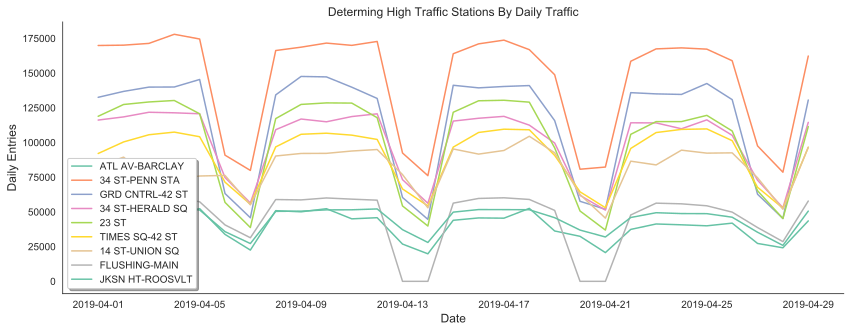

In [116]:
# Plot daily traffic for top trains for April only to more cleanly visualize patterns
daily_station_entries = mta_daily.groupby('station')['daily_entries'].agg(['mean'])

plt.figure(figsize=(14,5))

for sta in all_top_sta:
    single_station = grouped_by_station_and_day[grouped_by_station_and_day.station == sta]
    ss_boundary = single_station[(single_station.date >= pd.to_datetime('2019-04-1').date()) & (single_station.date <= pd.to_datetime('2019-04-29').date())]
    time_plot = sns.lineplot(x=ss_boundary.date, y = ss_boundary.daily_entries, label=sta);
    
time_plot.legend(loc=3, fontsize='10', shadow=True);
time_plot.set_title('Determing High Traffic Stations By Daily Traffic', fontsize=12)
time_plot.set_ylabel('Daily Entries', fontsize=12)
time_plot.set_xlabel('Date', fontsize=12);
sns.despine()
sns.set_style('white')
sns.set_palette("Set2");

plt.savefig("Apr_Determing_high_traffic_stations_by_daily_traffic.png")

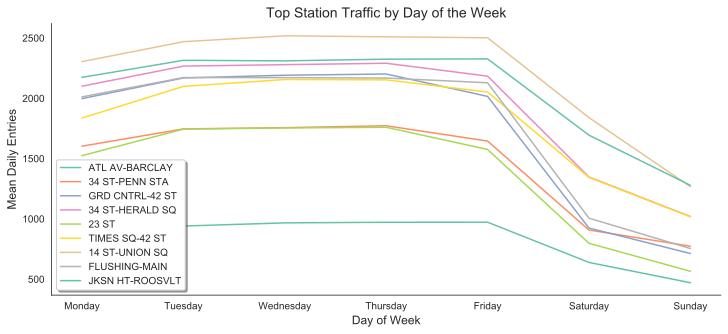

In [118]:
#Identify traffic by day of week for the top stations to determine optimal street team posting dates
grp_by_sta_dow = mta_daily.groupby(['station', 'dow', 'dow_num'])['daily_entries'].agg([np.mean]).reset_index()
grp_by_sta_dow = grp_by_sta_dow.rename(columns={'mean': 'mean_dow_entries'})

plt.figure(figsize=(12,5))
    
days = ['','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
for sta in all_top_sta:
    single_station = grp_by_sta_dow[grp_by_sta_dow.station == sta].sort_values(by='dow_num')
    dow_plot = sns.lineplot(x=single_station.dow_num, y = single_station.mean_dow_entries, label=sta);
    
dow_plot.legend(fontsize='10', shadow=True, loc=3);
dow_plot.set_title('Top Station Traffic by Day of the Week', fontsize=14)
dow_plot.set_ylabel('Mean Daily Entries', fontsize=12)
dow_plot.set_xlabel('Day of Week', fontsize=12);
dow_plot.set_xticklabels(labels=days)

sns.despine()
sns.set_style('white')
sns.set_palette("Set2");

plt.savefig("Top_station_traffic_by_day_of_week.png")

# Determining the Best Time of Day to Deploy Marketing Teams

Due to day light savings, some of the data has recordings at hours 0,4,8,12,16,20,24 while other data has recordings at hours 0,3,7,11,15,19,23. Error causes various recordings to occur between the standard 4 hour increments. To account for hourly variations and daylight savings, grouping hourly data into 3 hour increments

In [91]:
# Due to day light savings, some of the data has recordings at hours 0,4,8,12,16,20,24 while other data has recordings at hours 0,3,7,11,15,19,23
# Error causes various recordings to occur between the standard 4 hour increments 
# To account for hourly variations and daylight savings, grouping hourly data into 3 hour increments

def top_station_dataset(data, list_of_stop_stations):
    """Reduces dataset to only the top stations to decrease computation and time needed for executions."""
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = list_of_stop_stations

    all_days_top_sta = mta_hourly[(mta_hourly.station == x1) |
                                  (mta_hourly.station == x2) |
                                  (mta_hourly.station == x3) |
                                  (mta_hourly.station == x4) |
                                  (mta_hourly.station == x5) |
                                  (mta_hourly.station == x6) |
                                  (mta_hourly.station == x7) |
                                  (mta_hourly.station == x8) |
                                  (mta_hourly.station == x9) 
                                 ]
    return all_days_top_sta

def define_hour_groups(data):
    for row in data.index:
        if data.loc[row, 'datetime'] == 0:
            data.loc[row, 'hour_group'] = 0
        elif 0 < data.loc[row, 'datetime'] <= 3:
            data.loc[row, 'hour_group'] = 3
        elif 3 < data.loc[row, 'datetime']  <= 6:
            data.loc[row, 'hour_group'] = 6
        elif 6 < data.loc[row, 'datetime']  <= 9:
            data.loc[row, 'hour_group'] = 9
        elif 9 < data.loc[row, 'datetime']  <= 12:
            data.loc[row, 'hour_group'] = 12
        elif 12 < data.loc[row, 'datetime'] <= 15:
            data.loc[row, 'hour_group'] = 15
        elif 15 < data.loc[row, 'datetime']  <= 18:
            data.loc[row, 'hour_group'] = 18
        elif 18 < data.loc[row, 'datetime'] <= 21:
            data.loc[row, 'hour_group'] = 21
        elif 21 < data.loc[row, 'datetime'] <= 24:
            data.loc[row, 'hour_group'] = 24
    return data

def entries_per_hour_block(data, top_stations_list):
    """
    Calls helper functions to isolate the dataset to only top stations, 
    group the data into 3 hour blocks of time and compute entries within those hourly times.
    Returns a dataset grouped by time block.
    """
    
    #isolate dataset to only the top stations
    all_days_top_sta = top_station_dataset(mta_hourly, all_top_sta)
    
    hourly_dow = all_days_top_sta.groupby(['dow', all_days_top_sta.datetime.dt.hour])['hourly_entries'].agg(['mean']).reset_index()
    hourly_dow = hourly_dow.rename(columns={'mean':'hourly_mean'})
    
    # create hour blocks
    hourly_dow = define_hour_groups(hourly_dow)
    
    # compute entries within hourly blocks
    grp_hourly_dow = hourly_dow.groupby(['dow', 'hour_group'])['hourly_mean'].agg(['sum']).reset_index()
    grp_hourly_dow = grp_hourly_dow.rename(columns = {'sum': 'entries_per_hour_group'})
    
    return grp_hourly_dow

grp_hourly_dow = entries_per_hour_block(all_days_top_sta)

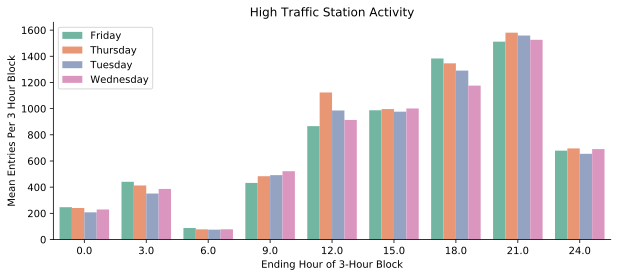

In [97]:
#plot hourly traffic for the busiest days of the week to determine posting times
days = ['Tuesday', 'Wednesday', 'Thursday', 'Friday']
peak_days = grp_hourly_dow[(grp_hourly_dow.dow == 'Tuesday') |
                       (grp_hourly_dow.dow == 'Wednesday') | 
                       (grp_hourly_dow.dow == 'Thursday') | 
                       (grp_hourly_dow.dow == 'Friday')  
                      ]
plt.figure(figsize=(10,4))
bar_time = sns.barplot(x=peak_days.hour_group, y = peak_days.entries_per_hour_group, hue=peak_days.dow);


bar_time.legend(fontsize='10', loc=2)
bar_time.set_title('High Traffic Station Activity')
bar_time.set_ylabel('Mean Entries Per 3 Hour Block')
bar_time.set_xlabel('Ending Hour of 3-Hour Block')
plt.savefig("Station_Traffic_By_Hour.png")
sns.set_palette("Set2")
sns.despine()

plt.savefig("Peak_days_Station_Traffic_By_Hour.png")


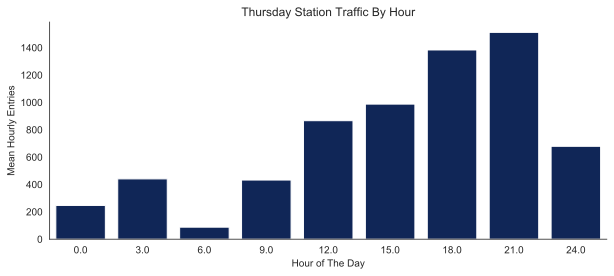

In [131]:
# Plotting for only Friday for sipmle visualization
thursday_hours = grp_hourly_dow[(grp_hourly_dow.dow == 'Thursday')]
plt.figure(figsize=(10,4))
bar_time = sns.barplot(x=single_day.hour_group, y = single_day.entries_per_hour_group, color='#042263FF');


bar_time.set_title('Thursday Station Traffic By Hour')
bar_time.set_ylabel('Mean Hourly Entries')
bar_time.set_xlabel('Hour of The Day')
sns.despine()

plt.savefig("Thursday_Station_Traffic_By_Hour.png")